<a href="https://colab.research.google.com/github/jgaomcintosh/TeamUltron/blob/main/Baseline_Reverse_Image_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Import the required libraries. Here we use tensorflow, keras, sklearn, matplot, and numpy.

In [2]:
import requests
import os
import numpy as np
from numpy.linalg import norm
import joblib as pickle
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
!sudo pip3 install keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
#from tensorflow.keras.applications.MobileNet import MobileNetV2,preprocess_input
#from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA


Grabbing the LFW dataset and preparing it for the model.

In [3]:
url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
r = requests.get(url)
filename = '101_ObjectCategories.tar.gz'
folderdername = filename.split('.')[0]
open(filename , 'wb').write(r.content)
# reference https://stackoverflow.com/questions/30887979/i-want-to-create-a-script-for-unzip-tar-gz-file-via-python
import tarfile
if filename.endswith("tar.gz"):
    tar = tarfile.open(filename, "r:gz")
    tar.extractall()
    tar.close()
elif filename.endswith("tar"):
    tar = tarfile.open(filename, "r:")
    tar.extractall()
    tar.close()

Defining our ResNet50 model. We remove the top layers and use a model which has been pretrained on ImageNet. Our model therefore returns a feature map and not classification probabilities.

In [5]:
img_size =224
model = ResNet50(include_top=False, weights='imagenet',input_shape=(img_size, img_size, 3),pooling='max')

94781440/94765736 [==============================] - 1s 0us/step


Now we pass the LFW dataset through our pretrained model and generate feature maps for each image in the dataset.

In [6]:
batch_size = 64
root_dir = '/content/lfw'

img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

datagen = img_gen.flow_from_directory(root_dir,
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))
feature_list = model.predict(datagen, num_epochs)
print("Num images   = ", len(datagen.classes))
print("Shape of feature_list = ", feature_list.shape)

Found 13233 images belonging to 5749 classes.
Num images   =  13233
Shape of feature_list =  (13233, 2048)


In [7]:
# Get full path for all the images in our dataset
filenames = [root_dir + '/' + s for s in datagen.filenames]

Here we fit the KNN algorithm to the LFW features. This will allow us to then compare input images to the LFW dataset and select the most similar images based upon feature distance. We choose $k$ to be 8.

In [8]:
neighbors = NearestNeighbors(n_neighbors=20,
                             algorithm='ball_tree',
                             metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree', metric='euclidean', n_neighbors=20)

Here we upload a test image (George W. Bush) and pass it through our model and KNN algorithm. We are then given the indices of the $k=8$ nearest neighbors.

In [9]:
#Load Data from Google Drive 
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

query_file_path= '/content/drive/MyDrive/query'
#query image file paths: query_file_path + '/' + 

# 10 QUERY IMAGE FILE PATHS
  # /content/drive/MyDrive/query/Albert_Costa_0001.jpeg
  # /content/drive/MyDrive/query/Angela_Bassett_0001.jpeg
  # /content/drive/MyDrive/query/Arminio_Fraga_0001.jpeg
  # /content/drive/MyDrive/query/Billy_Crystal_0001.jpeg
  # /content/drive/MyDrive/query/Bob_Graham_0001.jpeg
  # /content/drive/MyDrive/query/Boris_Becker_0001.jpeg
  # /content/drive/MyDrive/query/Bulent_Ecevit_0001.jpeg
  # /content/drive/MyDrive/query/Calista_Flockhart_0001.jpeg
  # /content/drive/MyDrive/query/Cameron_Diaz_0001.jpeg
  # /content/drive/MyDrive/query/Carmen_Electra_0001.jpeg

img_path = '/content/drive/MyDrive/query/Albert_Costa_0001.jpeg'
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)
test_img_features = model.predict(preprocessed_img, batch_size=1)

_, indices = neighbors.kneighbors(test_img_features)

Mounted at /content/drive


Here we loop through the LFW dataset to find the 8 most similar images, which correspond to our indices found above.

In [10]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(4,5,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')            
            plotnumber+=1
    plt.tight_layout()

Now printing the input image and the result from above

(1, 20)


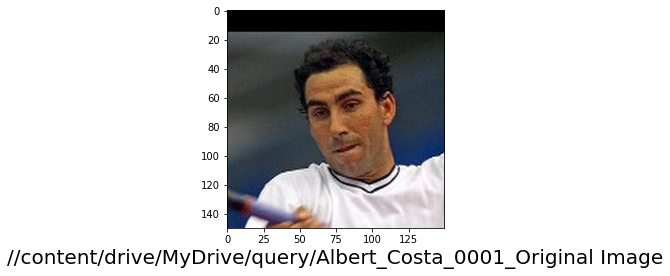

********* Predictions ***********


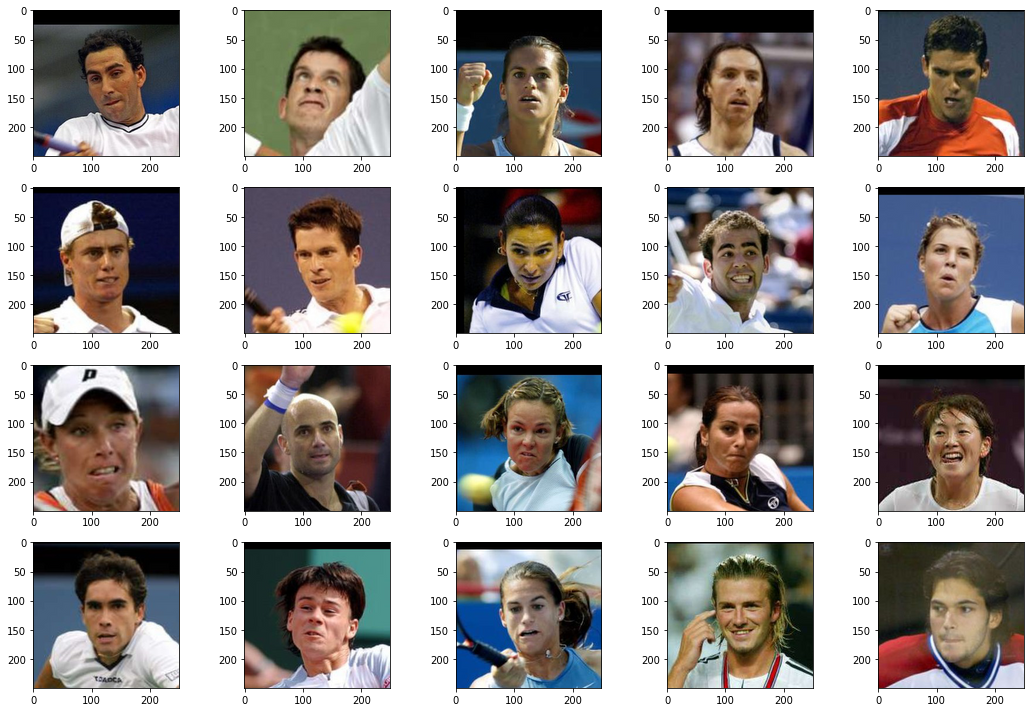

In [11]:
print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

Next we attempt to reduce the size of our feature maps to eradicate potential noise/overfitting. 

In [12]:
pca = PCA(n_components=1500)
pca.fit(feature_list)
compressed_features = pca.transform(feature_list)

In [13]:
neighbors_pca_features = NearestNeighbors(n_neighbors=20,
                             algorithm='ball_tree',                               metric='euclidean')
neighbors_pca_features.fit(compressed_features)

NearestNeighbors(algorithm='ball_tree', metric='euclidean', n_neighbors=20)

However we find negligible (and even decreasing) changes in performance after this change.

(1, 20)


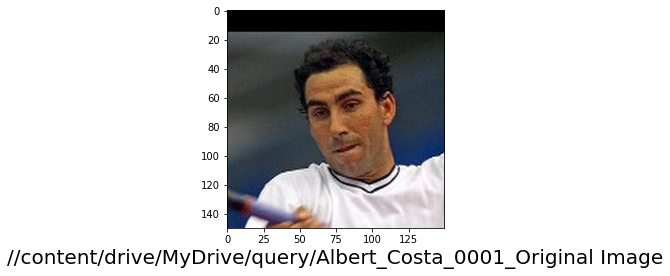

********* Predictions ***********


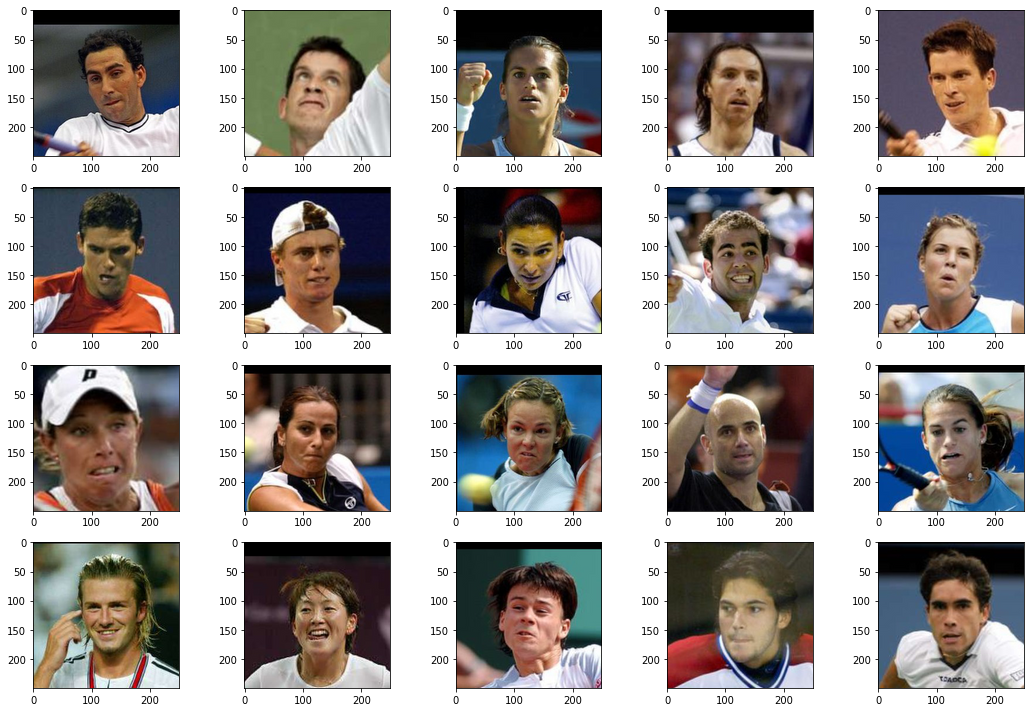

In [14]:
test_img_compressed = pca.transform(test_img_features)
distances, indices = neighbors_pca_features.kneighbors(test_img_compressed)
print(indices.shape)
plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])